In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

from scipy.integrate import solve_ivp

plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

We first consider the simple SIS model.

In [2]:
def dy_dt(t, y, beta, gamma):
    dS_dt = -beta*y[0]*y[1] + gamma*y[1]
    dI_dt = -dS_dt
    return np.array([dS_dt, dI_dt])

In [3]:
def gillespie_sis(graph, beta, gamma, I0, T):
    
    # Initialize the model
    S = graph.number_of_nodes() - I0
    I = I0
    t = 0

    # Assign initial infected nodes randomly
    infected_nodes = set(np.random.choice(graph.nodes, size=I0, replace=False))
    nx.set_node_attributes(graph, values=dict.fromkeys(infected_nodes, 'i'), name='status')
    nx.set_node_attributes(graph, values=dict.fromkeys(graph.nodes-infected_nodes, 's'), name='status')
    
    # Find the susceptible neighbors
    susceptible_neighbors = {
        infected_node: {neighbor for neighbor in graph.neighbors(infected_node)
                        if graph.nodes[neighbor]["status"] != "i"}
        for infected_node in infected_nodes
    }
    infected_nodes = {infected_node: len(susceptible_neighbors[infected_node]) for infected_node in infected_nodes}
    N_SI = sum([infected_nodes[infected_node] for infected_node in infected_nodes])

    # Initialize the results list
    results = [(t, S, I)]

    # Main loop
    while t < T and I > 0:
        # Calculate the propensities of events
        print('t = {:.2f}'.format(t), end="\r")
        a1 = beta * N_SI
        a2 = gamma * I
        a0 = a1 + a2

        # Terminate if no more events can occur
        if a0 == 0:
            break

        # Generate two random numbers
        r1, r2 = np.random.rand(2)

        # Determine the time to the next event
        dt = -np.log(r1) / a0
        t += dt

        # Determine which event occurs
        array_infected_nodes = np.array(list(infected_nodes.items()))
        if r2 < a1 / a0:
            # Infection event
            infected_node = np.random.choice(array_infected_nodes[:,0], 
                                             p=array_infected_nodes[:,1]/array_infected_nodes[:,1].sum())
            new_infected = np.random.choice(list(susceptible_neighbors[infected_node]))
            graph.nodes[new_infected]['status'] = 'i'
            infected_nodes[new_infected] = 0
            
            susceptible_neighbors[new_infected] = set()
            for neighbor in graph.neighbors(new_infected):
                if graph.nodes[neighbor]["status"] != 'i':
                    susceptible_neighbors[new_infected].add(neighbor)
                    infected_nodes[new_infected] += 1
                    N_SI += 1
                else:
                    susceptible_neighbors[neighbor].discard(new_infected)
                    infected_nodes[neighbor] -= 1
                    N_SI -= 1
                                
            S -= 1
            I += 1
        
        else:
            # Recovery event
            recovered_node = np.random.choice(array_infected_nodes[:,0])
            graph.nodes[recovered_node]["status"] = "s"
            infected_nodes.pop(recovered_node)
            
            for neighbor in graph.neighbors(recovered_node):
                if graph.nodes[neighbor]["status"] != 'i':
                    N_SI -= 1
                else:
                    susceptible_neighbors[neighbor].add(recovered_node)
                    infected_nodes[neighbor] += 1
                    N_SI += 1
                    
            S += 1
            I -= 1
                    
        results.append((t, S, I))

    return np.array(results)

In [37]:
population_size = 1000
time_horizon = 50
n_points = 1000

network_power_scale = nx.barabasi_albert_graph(n=population_size, m=20)

beta_mixed = 0.19
beta_network = beta_mixed / np.array(network_power_scale.degree)[:,1].mean()
gamma = 0.2

i0 = 0.01

solution = solve_ivp(fun=dy_dt, y0=(1-i0, i0), args=(beta_mixed, gamma),
                     t_span=(0,time_horizon), 
                     t_eval=np.linspace(0,time_horizon,n_points))

In [38]:
I0 = 10
results = gillespie_sis(network_power_scale, beta_network, gamma, I0, time_horizon)

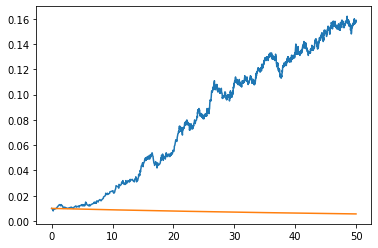

In [39]:
plt.plot(results[:,0], results[:,2]/population_size)
plt.plot(solution.t, solution.y[1,:])

In [35]:
beta_mixed = 0.19
beta_network = beta_mixed / np.array(network_power_scale.degree)[:,1].mean()

beta_network/gamma

0.02423469387755102

In [36]:
np.array(network_power_scale.degree)[:,1].mean()/(np.array(network_power_scale.degree)[:,1].var() + np.array(network_power_scale.degree)[:,1].mean())

0.041108934481586965